# Tutorial 02-01. Simple sentiment analysis - 90% accuracy

## A bit of theory

### Task statement

In this tutorial we will try to create a model that can classify text into 2 categories:
* positive
* negative

There are 2 possible types of classification - **binary classification** and **multi-class classification**. Binary classification can only spread input values into two categories. However, multi-class classification can extend to several classes.

To make our model universal, we will use a **multi-class classification** approach, even if we expect only 2 classes in the output.

Let's think about how we can implement this model. We prefer to have our model discover some patterns based on sample data and then apply those patterns to some other text messages. For simplicity, a training dataset is included - airline-tweets.csv. This is a list of people's comments, which already has information about whether the comment is positive or negative.

The input to our model should be text. The result is the class number. Let's say 0 for positive comments and 1 for negative ones. So what is the approach to classify a text?

Let's implement a simple but reliable solution

### Text classification

**Step 1. Text into numbers**

The first piece of the puzzle is the text. How can we convert it to a number? There are many ways to do this. Initially, we agreed to implement a simple working solution. The easiest one I can think of is to number the words in the order in which they appear.

The first word will become - 1, the second one - 2, etc. If the same word appears more than once, we reuse the number already assigned to it.

For example: *"I like this"* will become a vector of *[1,2,3]*. *"I don't like this"* will become *[1,4,3]*, due to *"I"* and *"this"* appeared earlier and already got a number. Our vocabulary will grow message by message. This step is illustrated on the image below.

As a result, a text message becomes a vector of numbers

**Step 2. Add weights**

At this stage we have a vector of numbers that can be converted back to text if necessary. These numbers mean nothing to a computer and cannot help it understand what to do with them. Let's imagine that each word in our dictionary can have a weight that can determine whether the word is positive or negative.

We will not assign a weight to each word manually, at least because we do not know the weights. This task will also require a lot of time. Instead, we can train a neaural network to assign a weight to a word based on sample data. This looks like a classic AI task. Let's skip the implementation for now. The key thing for us is that this layer will contain a weight of each word in the dictionary. When we pass a numeric vector to this layer, it should return a vector of associated weights.

Example:
* Step 1. "I like this" -> [1,2,3]
* Step 2. [1,2,3] -> [0.01, 0.8, 0.1]

As we said before, we don't care what weights are stored in this layer initially. We'll train them. Just for information, this layer is called **Embedding**

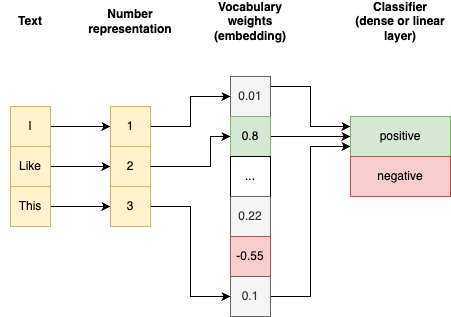

**Step 3. Classification**

At this stage we have a vector of weights. Not it's relatively simple to spread these weights into one of the classification groups. This is another classical AI task.

To classify some data we'll user **Dense** or **Linear** layer (another name).

**We are ready for the implementation!**

## Preparation

Let's install and import all needed python packages

In [1]:
# Important! If there is an error while you importing any of the packages below, you need to install
# them manually. To do this, call "pip install" command for each missing package as is shown below
# 
# Example: !pip install torchtext

In [2]:
import pandas as pd
import torch
import re
import matplotlib.pyplot as plt

from torchtext.data import get_tokenizer
from collections import Counter
from tqdm import tqdm

In [3]:
# get device for training (cpu, cuda or mps)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"{device} device is used")

mps device is used


In [4]:
# display settings
torch.set_printoptions(precision=2, sci_mode=False)

## Reading sample datasets

Cool. We have a working environment. Let's have a look at the sample data we have and try to analyse it

In [5]:
# load datasets
training_data_raw = pd.read_csv('./datasets/airline-tweets.csv')

In [6]:
training_data_raw.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [7]:
# rename columns for consistency. It will give us an opportunity to work with other datasets as well.
# We also leave only two columns (sentiments, text) to exclude unused data
training_data = training_data_raw.rename(columns={'airline_sentiment': 'sentiment', 'text': 'text'})
training_data = training_data[['sentiment','text']]

print('Total:', len(training_data))
training_data.head(10)

Total: 14640


,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


In [8]:
# leave only 'positive' and 'negative' comments
training_data = training_data[(training_data['sentiment'] == 'positive') | (training_data['sentiment'] == 'negative')]

print('Total:', len(training_data))
training_data.head(10)

Total: 11541


,sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."
11,positive,@VirginAmerica I &lt;3 pretty graphics. so muc...
12,positive,@VirginAmerica This is such a great deal! Alre...
13,positive,@VirginAmerica @virginmedia I'm flying your #f...


<Axes: >

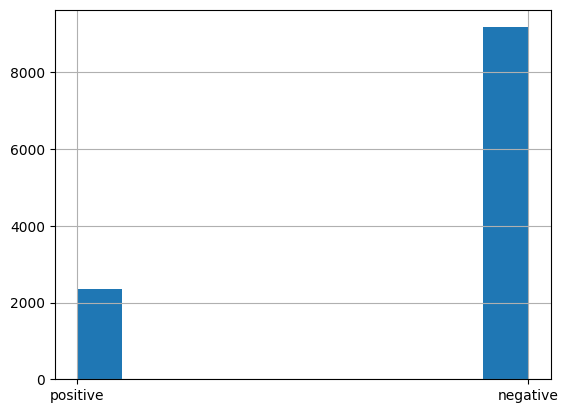

In [9]:
# training dataset statistics
training_data['sentiment'].hist()

## Step 1-1. Convert sentiment classes into numbers

At this step we'll convert classes ('positive', 'negative') into their number representation (0,1)

In [10]:
# classes
unique_classes = training_data['sentiment'].unique()

total_classes = len(unique_classes)
classes_index_to_name = dict((i,v) for i,v in enumerate(unique_classes))
classes_name_to_index = dict((v,i) for i,v in enumerate(unique_classes))

print('Classes (index to name): ', classes_index_to_name)
print('Classes (name to index): ', classes_name_to_index)

Classes (index to name):  {0: 'positive', 1: 'negative'}
Classes (name to index):  {'positive': 0, 'negative': 1}


In [11]:
# convert classes into numbers
# example: positive -> 0, negative -> 1
def classes_to_numbers(class_names):
    return [classes_name_to_index[x] for x in class_names]
    
# convert class numbers into vectors
# example: 0 -> [0,1]; 1 -> [1,0]
def class_into_vector(class_index, max_classes):
    result = torch.full((1, max_classes), 0).view(max_classes)
    result[class_index] = 1
    return result.tolist()

# example: ['negative', 'positive'] -> [[0,1], [1,0]]
def classes_into_vectors(class_names):
    return [class_into_vector(class_value, total_classes) for class_value in classes_to_numbers(class_names)]

In [12]:
training_classes = classes_into_vectors(training_data['sentiment'])
training_classes[:20]

[[1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1]]

## Step 1-2. Convert text into numbers

At this step we'll convert a text into its number representation

In [13]:
# convert comments into tokens
# example: ['hello world!'] => [['hello','world']]
def tokenize(comments):
    def remove_punctuation(text):
        return re.sub(r'[^a-zA-Z0-9\' ]+', ' ', text)
    
    # split each sentense into tokens
    tokenizer = get_tokenizer("basic_english")
    tokenized_items = [tokenizer(remove_punctuation(str(x))) for x in comments]

    return tokenized_items

# comments
tokenized_training_comments = tokenize(training_data['text'])

# statistics
training_longest_comment = max([len(x) for x in tokenized_training_comments])
training_shortest_comment = min([len(x) for x in tokenized_training_comments])
training_total_comments = len(tokenized_training_comments)

print('Total comment: ', training_total_comments)
print('Longest comment: ', training_longest_comment)
print('Shortest comment: ', training_shortest_comment)
print()
print('First 5 comments:\n{}'.format('\n'.join(map(str, tokenized_training_comments[:5]))))

Total comment:  11541
Longest comment:  36
Shortest comment:  2

First 5 comments:
['virginamerica', 'plus', 'you', "'", 've', 'added', 'commercials', 'to', 'the', 'experience', 'tacky']
['virginamerica', 'it', "'", 's', 'really', 'aggressive', 'to', 'blast', 'obnoxious', 'entertainment', 'in', 'your', 'guests', "'", 'faces', 'amp', 'they', 'have', 'little', 'recourse']
['virginamerica', 'and', 'it', "'", 's', 'a', 'really', 'big', 'bad', 'thing', 'about', 'it']
['virginamerica', 'seriously', 'would', 'pay', '30', 'a', 'flight', 'for', 'seats', 'that', 'didn', "'", 't', 'have', 'this', 'playing', 'it', "'", 's', 'really', 'the', 'only', 'bad', 'thing', 'about', 'flying', 'va']
['virginamerica', 'yes', 'nearly', 'every', 'time', 'i', 'fly', 'vx', 'this', 'ear', 'worm', 'won', 't', 'go', 'away']


In [14]:
# filter data
min_comment_length = 1

# this function will remove all comments and related classes if comment's length is less than 'min_comment_length'
def filter_data(comments, classes):
    filtered_data = filter(lambda p: len(p[0]) >= min_comment_length, zip(comments, classes))
    [filtered_comments, filtered_classes] = list(zip(*filtered_data))
    return (list(filtered_comments), list(filtered_classes))

(filtered_comments, filtered_classes) = filter_data(tokenized_training_comments, training_classes)

print('Total comment: ', len(filtered_comments))
print('Longest comment: ', max([len(x) for x in filtered_comments]))
print('Shortest comment: ', min([len(x) for x in filtered_comments]))

Total comment:  11541
Longest comment:  36
Shortest comment:  2


In [15]:
list(zip(filtered_comments, filtered_classes))[:10]

[(['virginamerica',
   'plus',
   'you',
   "'",
   've',
   'added',
   'commercials',
   'to',
   'the',
   'experience',
   'tacky'],
  [1, 0]),
 (['virginamerica',
   'it',
   "'",
   's',
   'really',
   'aggressive',
   'to',
   'blast',
   'obnoxious',
   'entertainment',
   'in',
   'your',
   'guests',
   "'",
   'faces',
   'amp',
   'they',
   'have',
   'little',
   'recourse'],
  [0, 1]),
 (['virginamerica',
   'and',
   'it',
   "'",
   's',
   'a',
   'really',
   'big',
   'bad',
   'thing',
   'about',
   'it'],
  [0, 1]),
 (['virginamerica',
   'seriously',
   'would',
   'pay',
   '30',
   'a',
   'flight',
   'for',
   'seats',
   'that',
   'didn',
   "'",
   't',
   'have',
   'this',
   'playing',
   'it',
   "'",
   's',
   'really',
   'the',
   'only',
   'bad',
   'thing',
   'about',
   'flying',
   'va'],
  [0, 1]),
 (['virginamerica',
   'yes',
   'nearly',
   'every',
   'time',
   'i',
   'fly',
   'vx',
   'this',
   'ear',
   'worm',
   'won',
   't',


In [16]:
# let's generate a vocabulary
def generate_vocabulary(comments):
    vocabulary = {}
    
    for comment in comments:
        for word in comment:
            if not (word in vocabulary):
                vocabulary[word] = len(vocabulary) + 1

    return vocabulary

vocabulary = generate_vocabulary(filtered_comments)
vocabulary_size = len(vocabulary)

print('Total words: {}\n'.format(vocabulary_size))
print('First 10 words: {}\n'.format(list(vocabulary.items())[:10]))

Total words: 12680

First 10 words: [('virginamerica', 1), ('plus', 2), ('you', 3), ("'", 4), ('ve', 5), ('added', 6), ('commercials', 7), ('to', 8), ('the', 9), ('experience', 10)]



In [17]:
vector_size = training_longest_comment

# convert tokens into numbers
# example: [['hello', 'world']] -> [[1761, 1521]]
def convert_tokens_into_numbers(vocabulary, comments):
    def convert(line):
        converted_line = []
        
        for word in line:
            if not (word in vocabulary):
                # we still add a new word do the dictionary if it doesn't exist
                vocabulary[word] = len(vocabulary) + 1

            converted_line.append(vocabulary[word])

        return converted_line

    return [convert(comment) for comment in comments]

# normalize tokens
# example: [[1, 20]] -> [[0,0,0,...,1, 20]]
def normalize_tokens(tokens, max_length):
    def normalize(line):
        line_length = len(line)
        if line_length == 0:
            return None  
        elif line_length > max_length:
            return line[line_length - max_length:]
        elif line_length < max_length:
            return [0] * (max_length - line_length) + line
        else:
            return line

    return [normalize(line) for line in tokens]

# convert to numbers
training_normalized_comments = normalize_tokens(
    convert_tokens_into_numbers(vocabulary, filtered_comments),
    vector_size
)

# display top 10 items
print('First 5 comments: {}\n'.format('\n'.join(map(str, training_normalized_comments[:5]))))

First 5 comments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 12, 4, 13, 14, 15, 8, 16, 17, 18, 19, 20, 21, 4, 22, 23, 24, 25, 26, 27]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 28, 12, 4, 13, 29, 14, 30, 31, 32, 33, 12]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 34, 35, 36, 37, 29, 38, 39, 40, 41, 42, 4, 43, 25, 44, 45, 12, 4, 13, 14, 9, 46, 31, 32, 33, 47, 48]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 49, 50, 51, 52, 53, 54, 55, 44, 56, 57, 58, 43, 59, 60]



## Split data into training and validation datasets

Let's split our sample data into two datasets:
* training dataset - will be used for training
* validation dataset - will be used for validation

In [18]:
# create dataset
dataset = torch.utils.data.TensorDataset(
    torch.tensor(training_normalized_comments, dtype=torch.int).to(device),
    torch.tensor(filtered_classes, dtype=torch.float).to(device)
)
print('Dataset length: ', len(dataset))

Dataset length:  11541


In [19]:
dataset[40]

(tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   1, 348, 349, 195, 327,   8, 220, 350,
          39,  69,  70, 219, 351, 259,  75, 159], device='mps:0',
        dtype=torch.int32),
 tensor([0., 1.], device='mps:0'))

In [20]:
# settings
training_split_ratio = 0.8

# split comments
torch.manual_seed(200)   # pseudo random values (debug only)

input_size = len(dataset)
train_size = int(training_split_ratio * input_size)
test_size = input_size - train_size

training_dataset_subset, validation_dataset_subset = torch.utils.data.random_split(dataset, [train_size, test_size])

print("Training dataset - {} indices".format(len(training_dataset_subset)))
print("Validation dataset - {} indices".format(len(validation_dataset_subset)))
print("Total: {} items".format(input_size))

Training dataset - 9232 indices
Validation dataset - 2309 indices
Total: 11541 items


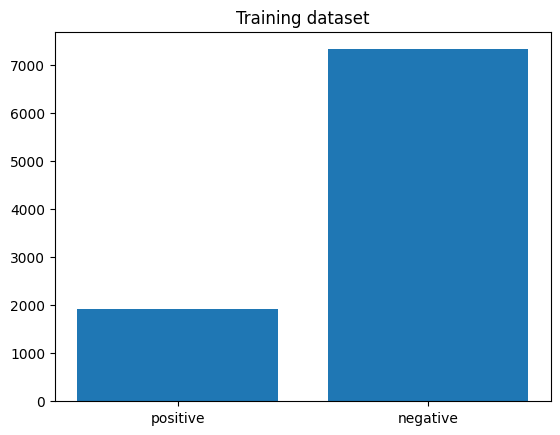

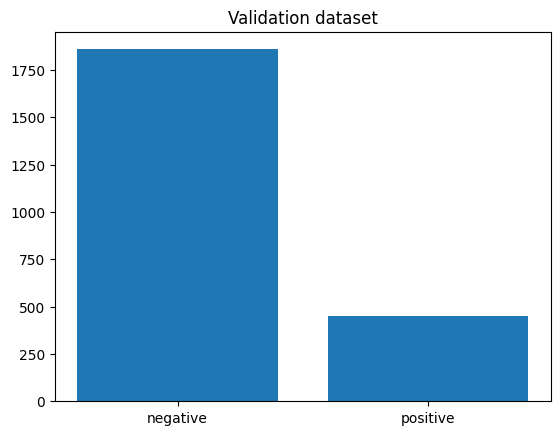

In [21]:
# let's visualize our datasets
def get_sentiment_class(dataset):
    counter = Counter()

    for i, (c,s) in enumerate(dataset):
        class_index = int((s.cpu() == 1).nonzero().squeeze())
        counter.update([classes_index_to_name[class_index]])

    return counter

training_dataset_statistics = get_sentiment_class(training_dataset_subset)
validation_dataset_statistics = get_sentiment_class(validation_dataset_subset)

plt.bar(training_dataset_statistics.keys(), training_dataset_statistics.values())
plt.title("Training dataset")
plt.show()

plt.bar(validation_dataset_statistics.keys(), validation_dataset_statistics.values())
plt.title("Validation dataset")
plt.show()

In [22]:
# split data into chunks
batch_size = 1
print('Batch size is: {}\n'.format(batch_size))

# training dataset
training_dataloader = torch.utils.data.DataLoader(training_dataset_subset, shuffle=False, batch_size=batch_size)
for i, (c,s) in enumerate(training_dataloader):
    print('Training dataset comments:', c)
    print('Training dataset classes:', s)
    break

print()

# validation dataset
validation_dataloader = torch.utils.data.DataLoader(validation_dataset_subset, shuffle=False, batch_size=batch_size)
for i, (c,s) in enumerate(validation_dataloader):
    print('Validation dataset comments:', c)
    print('Validation dataset classes:', s)
    break

Batch size is: 1

Training dataset comments: tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,  759, 1953,   80,   81,    3, 1954,
          350,   28,  198,   75,   29, 1955,  549, 1487, 1871,   24,   64, 1097]],
       device='mps:0', dtype=torch.int32)
Training dataset classes: tensor([[1., 0.]], device='mps:0')

Validation dataset comments: tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         407, 172,  20, 269, 422, 325, 325, 325]], device='mps:0',
       dtype=torch.int32)
Validation dataset classes: tensor([[0., 1.]], device='mps:0')


## Training

Awesome! Let's create our model and train it

In [23]:
# model
class SentimentModel(torch.nn.Module):
    _embedding_vector_size = 1
    
    def __init__(self, dim_in, dim_out, vocabulary_size):
        super().__init__()

        self._dim_in = dim_in
        self._dim_out = dim_out
        self._vocabulary_size = vocabulary_size
        
        self.embedding = torch.nn.Embedding(vocabulary_size, self._embedding_vector_size)
        self.linear = torch.nn.Linear(dim_in, dim_out)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(self._embedding_vector_size, self._dim_in)
        x = self.linear(x)
        
        return x

In [24]:
# let's create a model
dim_in, dim_out = vector_size, total_classes

model = SentimentModel(
    dim_in=dim_in,
    dim_out=dim_out,
    vocabulary_size=vocabulary_size
)
model.to(device)

SentimentModel(
  (embedding): Embedding(12680, 1)
  (linear): Linear(in_features=36, out_features=2, bias=True)
)

In [25]:
# settings
rate_learning = 0.001
max_iterations = 5
early_stop_loss = 0.0001
early_stop_max_count = -1

# training
def train(model, training_dataloader, validation_dataloader):
    # returns an amount of matched and not matched items
    # example:
    #   calculate_step_accuracy(
    #       predicted=torch.tensor([[-0.35,  0.87], [0.35,  0.87], [0,  1]]),
    #       expected=torch.tensor([[1., 0.], [0., 1.], [1., 0.]])
    #   )
    #
    #   passed - 1, failed - 2
    def calculate_accuracy(predicted, expected):
        passed = int(torch.sum(torch.argmax(predicted, dim=1) == torch.argmax(expected, dim=1)))
        failed = len(predicted) - passed
    
        return (passed, failed)

    # training loop
    def evaluate(dataloader, label='', isTraining=True):
        with tqdm(total=len(dataloader), desc=label,
                  bar_format='{desc}{percentage:3.0f}%|{bar:10}{r_bar}', leave=False) as progress:
            # batches
            passed, failed = 0, 0
            for i, (input, expected) in enumerate(dataloader):
                # predict model
                predicted = model(input)
                loss = loss_fn(predicted, expected)
                
                # back propagation
                if isTraining:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
    
                # accuracy
                (local_passed, local_failed) = calculate_accuracy(predicted, expected)
                
                passed = passed + local_passed
                failed = failed + local_failed
                accuracy = passed / (passed + failed)

                # progress bar
                progress.update(1)
                progress.set_postfix_str('loss={:.6f}, acc={:.4f}'.format(loss.item(), accuracy))

        return (loss, accuracy)

    # optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=rate_learning)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # dynamic params
    best_training_loss = None
    early_stop = early_stop_max_count
    statistics = []

    # epochs
    for epoch in range(1, max_iterations):
        # training
        (training_loss, training_acc) = evaluate(
            training_dataloader,
            label='Training {}/{}'.format(epoch, max_iterations),
            isTraining=True
        )
        

        # validation
        (validation_loss, validation_acc) = evaluate(
            validation_dataloader,
            label='Validation {}/{}'.format(epoch, max_iterations),
            isTraining=False
        )

        # update statistics
        statistics.append((training_acc, validation_acc))
    
        # check for early stop
        if early_stop_max_count > 0:
            need_to_stop = (best_training_loss is not None) and \
                           ((training_loss < best_training_loss) or abs(training_loss - best_training_loss) <= early_stop_loss)
            
            if need_to_stop:
                early_stop = early_stop - 1
                if early_stop <= 0:
                    print('Early stop. Previous loss {:.10f}, current loss {:.10f}:'.format(previous_loss, loss.item()))
                    break
            else:
                early_stop = early_stop_max_count

        best_training_loss = training_loss if best_training_loss is None else min(best_training_loss, training_loss)

    return (statistics)

In [26]:
# train model
(statistics) = train(model, training_dataloader, validation_dataloader)

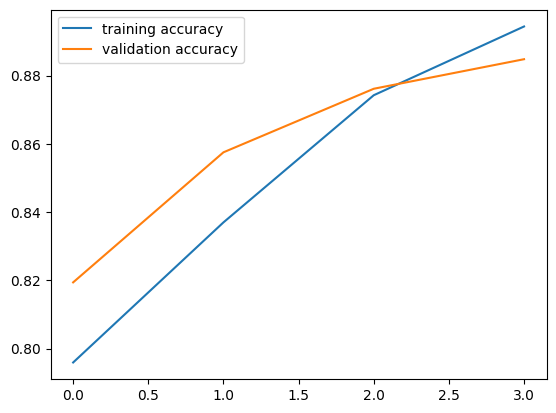

In [27]:
# display training process
[training_statistics, validation_statistics] = list(zip(*statistics))

plt.plot(range(len(training_statistics)), list(training_statistics), label='training accuracy')
plt.plot(range(len(validation_statistics)), list(validation_statistics), label='validation accuracy')
plt.legend()
plt.show()

## Testing

Let's try our model. To do so we can create two functions:
* the first one to calculate model's accuracy. It will basically evaluate each text message in a dataset and compare it with the expected value. As a result, we'll know the model's accuracy
* the second function which can be used to evaluate any random text expression even if id didn't exist in the sample dataset 

In [28]:
def evaluate(model, dataloader):
    passed, failed = 0, 0
    
    with tqdm(total=len(dataloader),
                  bar_format='{desc}{percentage:3.0f}%|{bar:10}{r_bar}') as progress:
        for i, (input,expected) in enumerate(dataloader):
            predicted = model(input)
    
            local_passed = int(torch.sum(torch.argmax(predicted, dim=1) == torch.argmax(expected, dim=1)))
            local_failed = len(predicted) - local_passed

            passed = passed + local_passed
            failed = failed + local_failed

            progress.update(1)

    return (passed, failed, passed / (passed + failed))

evaluate(model, validation_dataloader)

100%|██████████| 2309/2309 [00:02<00:00, 961.78it/s] 


(2043, 266, 0.8847986141186661)

In [29]:
def evaluate_text(text):
    tokens = normalize_tokens(
        convert_tokens_into_numbers(vocabulary, tokenize([text])),
        vector_size
    )

    tensor = torch.tensor(tokens).to(device)
    
    predicted = model(tensor)

    class_index = int(torch.argmax(predicted))
    return (text, classes_index_to_name[class_index])

print(evaluate_text('Very good!'))
print(evaluate_text('I like this!'))
print(evaluate_text('This is terrible!'))
print(evaluate_text('I don\'t like this!'))

('Very good!', 'positive')
('I like this!', 'positive')
('This is terrible!', 'negative')
("I don't like this!", 'negative')
